In [2]:
from diffmd.diffeqs import ODEFunc
from diffmd.solvers import odeint_adjoint
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.offsetbox import AnchoredText
from matplotlib.gridspec import GridSpec
import seaborn as sns


In [3]:
torch.cuda.empty_cache()
from diffmd.training import Trainer

config = dict(
    folder = 'dataset/trajectories/thesis/', 
    device = torch.device("cpu"), 
    niters = 50000,
    start_niter = 0,
    optimizer = 'Adam',
    batch_length=20,
    nbatches=600,
    learning_rate=0.020,
    nn_depth=2,
    nn_width=1000,
    activation_function=None,
    load_folder='results/overfitted/depth-2-width-1000-lr-0.01-loss-all/',
    # load_folder=None,
    dtype=torch.float32,
    printing_freq=100,
    plotting_freq=500,
    stopping_freq=10000,
    scheduler='LambdaLR',
    scheduling_factor=0.85,
    scheduling_freq=5000,
    evaluation_freq=500,
    checkpoint_freq=500,
    loss_func = 'all'
    )

trainer = Trainer(config)


Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100
device = cpu
dataset = ['NVE-temp-0.5_K-3.96851711369462_r-2_s-5'] in dataset/trajectories/thesis/
depth = 2, width = 1000
number of parameters = 1014001
learning rate = 0.02, optimizer = Adam
scheduler = LambdaLR, scheduling factor = 0.85, scheduling freq = 5000
number of batches = 600, batch length = 20


In [4]:
losses_both = []
stds_both = []
losses_trans = []
stds_trans = []
losses_rot = []
stds_rot = []

with torch.no_grad():
    traj_lengths = [100, 200, 500, 1000, 2000, 5000, 10000]
    for traj_length in traj_lengths:
        traj = trainer.dataset.trajs[0].traj
        nbatches = 100 
        dt = trainer.dataset.trajs[0].dt
        batch_t, batch_y0, batch_y, trainer.func.k, trainer.func.inertia, trainer.batch_filepath = trainer.dataset.get_batch(nbatches, traj_length)   
        pred_y = odeint_adjoint(trainer.func, batch_y0, batch_t, method='NVE')
        pred_y = torch.cat(pred_y, dim=-1).cpu().numpy()
        batch_y = torch.swapaxes(torch.cat(batch_y, dim=-1), 0, 1).cpu().numpy()
        batch_t = batch_t.cpu().numpy()

        q = np.abs(pred_y - batch_y)
        losses_both.append(np.mean(q))
        stds_both.append(np.std(np.mean(q, axis=(1, 2, 3))))
        
        q = np.abs(pred_y - batch_y)[:, :, :, [0, 1, 2, 6, 7, 8]]
        losses_trans.append(np.mean(q))
        stds_trans.append(np.std(np.mean(q, axis=(1, 2, 3))))

        q = np.abs(pred_y - batch_y)[:, :, :, [3, 4, 5, 9, 10, 11, 12]]
        losses_rot.append(np.mean(q))
        stds_rot.append(np.std(np.mean(q, axis=(1, 2, 3))))
          

In [10]:
with torch.no_grad():
    traj = trainer.dataset.trajs[0].traj
    traj_length = 5000
    nbatches = 1 
    dt = trainer.dataset.trajs[0].dt
    batch_t, batch_y0, batch_y, trainer.func.k, trainer.func.inertia, trainer.batch_filepath = trainer.dataset.get_batch(nbatches, traj_length)   
    pred_y = odeint_adjoint(trainer.func, batch_y0, batch_t, method='NVE')
    pred_y = torch.cat(pred_y, dim=-1).cpu().numpy()
    batch_y = torch.swapaxes(torch.cat(batch_y, dim=-1), 0, 1).cpu().numpy()
    batch_t = batch_t.cpu().numpy()
                

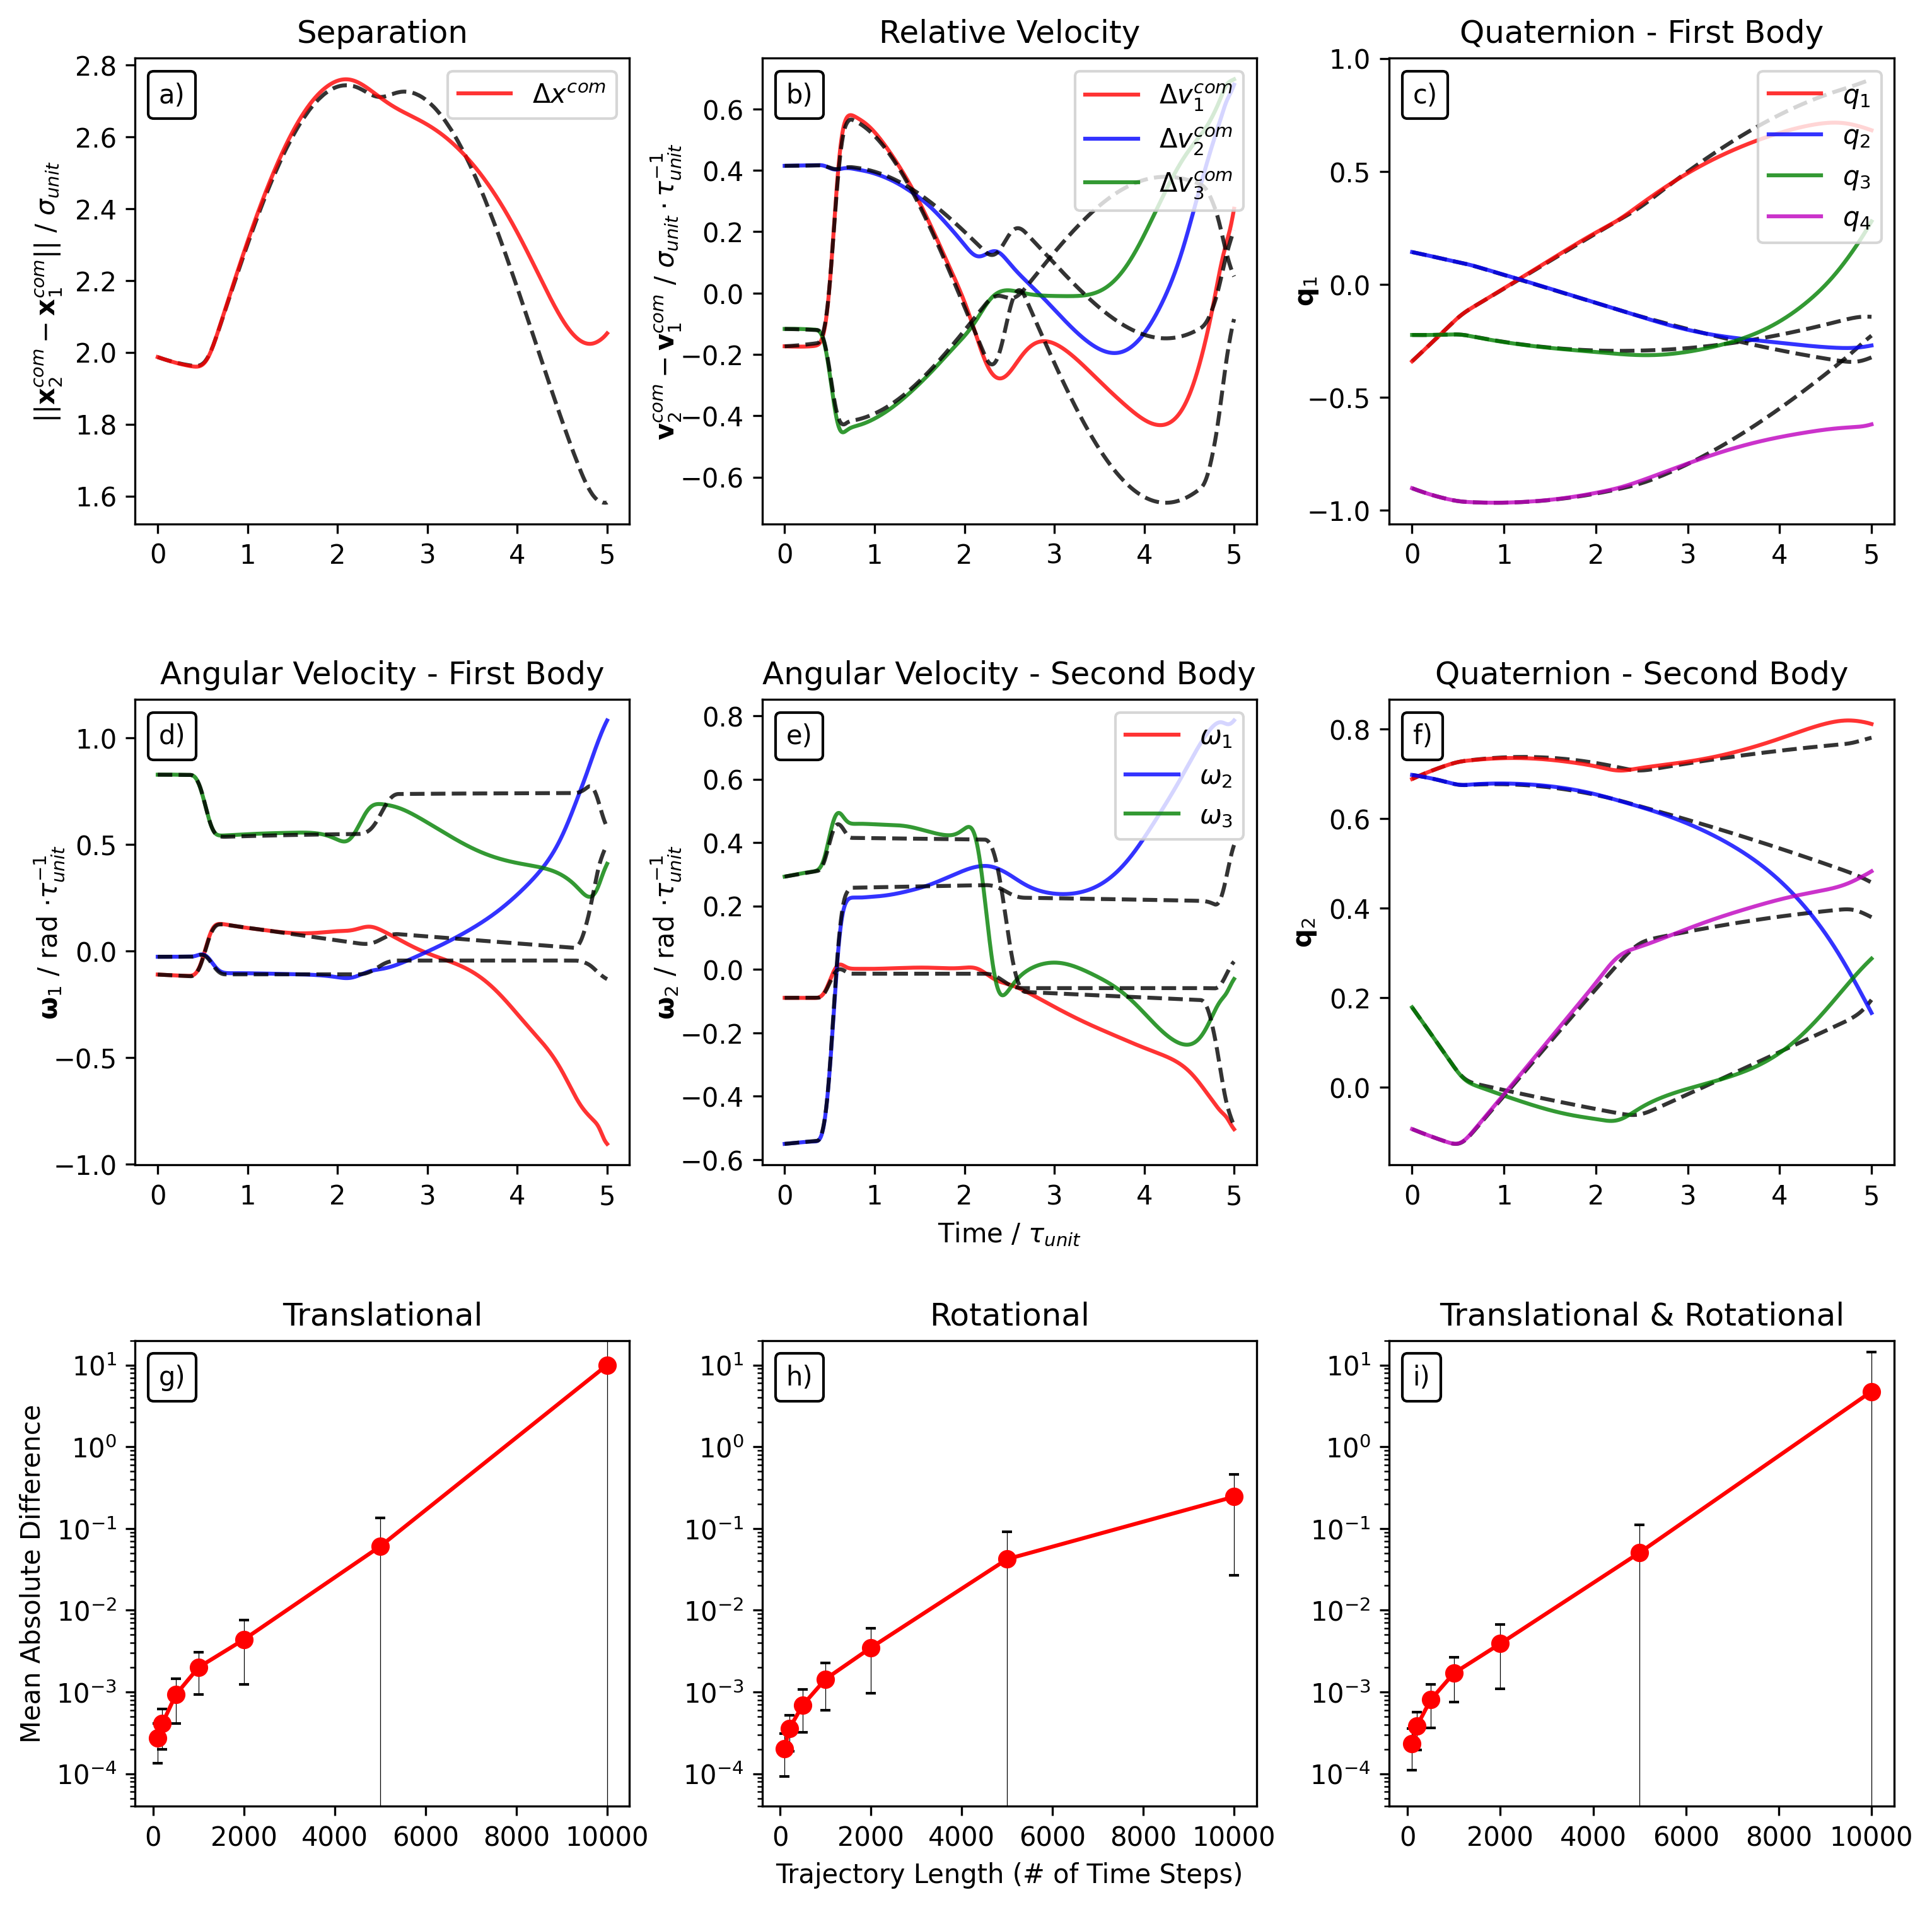

In [32]:
fig = plt.figure(figsize=(12,12), dpi=300)
axs = [0 for i in range(9)]
width = 480
height = 600
triple_width = 135
triple_width_delta = (width - 3 * triple_width) // 4
double_width = 220
double_width_delta = (width - 2 * double_width) // 2


gs = GridSpec(height, width, figure=fig)

axs[0] = fig.add_subplot(gs[:160, :triple_width])
axs[1] = fig.add_subplot(gs[:160, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
axs[2] = fig.add_subplot(gs[:160, (2*triple_width + 4*triple_width_delta):])


axs[3] = fig.add_subplot(gs[220:380, :triple_width])
axs[4] = fig.add_subplot(gs[220:380, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
axs[5] = fig.add_subplot(gs[220:380, (2*triple_width + 4*triple_width_delta):])

axs[6] = fig.add_subplot(gs[440:, :triple_width])
axs[7] = fig.add_subplot(gs[440:, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
axs[8] = fig.add_subplot(gs[440:, (2*triple_width + 4*triple_width_delta):])

sep = np.linalg.norm(batch_y[:,:,1,[6, 7, 8]] - batch_y[:,:, 0,[6, 7, 8]], axis=2).squeeze()
pred_sep = np.linalg.norm(pred_y[:,:,1,[6, 7, 8]] - pred_y[:,:, 0,[6, 7, 8]], axis=2).squeeze()
axs[0].plot(batch_t, sep, 'k--', alpha=0.8)
axs[0].plot(batch_t, pred_sep, 'r-', alpha=0.8, label='$\Delta x^{com}$')
axs[0].legend(loc='upper right')
axs[0].set_ylabel(r'$||\mathbf{x}^{com}_2 - \mathbf{x}^{com}_1||$ / $\sigma_{unit}$')
axs[0].set_title('Separation')


rel_vel = (batch_y[:,:,1,[0, 1, 2]] - batch_y[:,:, 0,[0, 1, 2]]).squeeze()
pred_rel_vel = (pred_y[:,:,1,[0, 1, 2]] - pred_y[:,:, 0,[0, 1, 2]]).squeeze()
axs[1].plot(batch_t, pred_rel_vel[:, 0], 'r-', alpha=0.8, label='$\Delta v_1^{com}$')
axs[1].plot(batch_t, pred_rel_vel[:, 1], 'b-', alpha=0.8, label='$\Delta v_2^{com}$')
axs[1].plot(batch_t, pred_rel_vel[:, 2], 'g-', alpha=0.8, label='$\Delta v_3^{com}$')
axs[1].plot(batch_t, rel_vel, 'k--', alpha=0.8)
axs[1].legend(loc='upper right')
axs[1].set_ylabel(r'$\mathbf{v}^{com}_2 - \mathbf{v}^{com}_1 $ / $\sigma_{unit} \cdot \tau_{unit}^{-1}$', labelpad=-1)
axs[1].set_title('Relative Velocity')


axs[3].plot(batch_t, pred_y[:,:,0,[3]].squeeze(), 'r-', alpha=0.8, label='$\omega_1$')
axs[3].plot(batch_t, pred_y[:,:,0,[4]].squeeze(), 'b-', alpha=0.8, label='$\omega_2$')
axs[3].plot(batch_t, pred_y[:,:,0,[5]].squeeze(), 'g-', alpha=0.8, label='$\omega_3$' )
axs[3].plot(batch_t, batch_y[:,:,0,[3, 4, 5]].squeeze(), 'k--', alpha=0.8)
# axs[3].legend(loc='upper right')
axs[3].set_ylabel(r'$\mathbf{\omega}_1$ / rad $\cdot \tau^{-1}_{unit}$', labelpad=-5)
axs[3].set_title('Angular Velocity - First Body')


axs[4].plot(batch_t, pred_y[:,:,1,[3]].squeeze(), 'r-', alpha=0.8, label='$\omega_1$')
axs[4].plot(batch_t, pred_y[:,:,1,[4]].squeeze(), 'b-', alpha=0.8, label='$\omega_2$')
axs[4].plot(batch_t, pred_y[:,:,1,[5]].squeeze(), 'g-', alpha=0.8, label='$\omega_3$' )
axs[4].plot(batch_t, batch_y[:,:,1,[3, 4, 5]].squeeze(), 'k--', alpha=0.8)
axs[4].legend(loc='upper right')
axs[4].set_ylabel(r'$\mathbf{\omega}_2$ / rad $\cdot \tau^{-1}_{unit}$', labelpad=-1)
axs[4].set_title('Angular Velocity - Second Body')

axs[2].plot(batch_t, batch_y[:,:,0,[9, 10, 11, 12]].squeeze(), 'k--', alpha=0.8)
axs[2].plot(batch_t, pred_y[:,:,0,[9]].squeeze(), 'r-', alpha=0.8, label='$q_1$')
axs[2].plot(batch_t, pred_y[:,:,0,[10]].squeeze(), 'b-', alpha=0.8, label='$q_2$')
axs[2].plot(batch_t, pred_y[:,:,0,[11]].squeeze(), 'g-', alpha=0.8, label='$q_3$')
axs[2].plot(batch_t, pred_y[:,:,0,[12]].squeeze(), 'm-', alpha=0.8, label='$q_4$')
axs[2].set_ylabel('$\mathbf{q}_1$', labelpad=-5)
axs[2].legend(loc='upper right')
axs[2].set_title('Quaternion - First Body')

axs[5].plot(batch_t, batch_y[:,:,1,[9, 10, 11, 12]].squeeze(), 'k--', alpha=0.8)
axs[5].plot(batch_t, pred_y[:,:,1,[9]].squeeze(), 'r-', alpha=0.8, label='$q_0$')
axs[5].plot(batch_t, pred_y[:,:,1,[10]].squeeze(), 'b-', alpha=0.8, label='$q_1$')
axs[5].plot(batch_t, pred_y[:,:,1,[11]].squeeze(), 'g-', alpha=0.8, label='$q_2$')
axs[5].plot(batch_t, pred_y[:,:,1,[12]].squeeze(), 'm-', alpha=0.8, label='$q_3$')
# axs[5].legend(loc='upper right')
axs[5].set_ylabel('$\mathbf{q}_2$')
axs[5].set_title('Quaternion - Second Body')

axs[4].set_xlabel(r'Time / $\tau_{unit}$')


axs[6].errorbar(traj_lengths, losses_trans, stds_trans, elinewidth=0.3, capsize=2, fmt='k', ls='none')
axs[6].plot(traj_lengths, losses_trans, 'ro-')
axs[6].set_title('Translational')

axs[7].errorbar(traj_lengths, losses_rot, stds_rot, elinewidth=0.3, capsize=2, fmt='k', ls='none')
axs[7].plot(traj_lengths, losses_rot, 'ro-')
axs[7].set_title('Rotational')


axs[8].set_title('Translational & Rotational')
axs[8].errorbar(traj_lengths, losses_both, stds_both, elinewidth=0.3, capsize=2, fmt='k', ls='none')
axs[8].plot(traj_lengths, losses_both, 'ro-')

axs[7].set_xlabel('Trajectory Length (# of Time Steps)')
axs[6].set_ylabel('Mean Absolute Difference')
    

for i in range(6, 9):
    axs[i].set_yscale('log')
plt.setp((axs[6], axs[7], axs[8]), ylim=(4e-5, 2e1))


labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)']
# labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for i, ax in enumerate(axs):
    at = AnchoredText(
        labels[i], prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

plt.savefig('figures/hexagon_results.png')
plt.show()
